In [1]:
# Runner script for InfoVAE by Ishraque Zahin, 45129256
# if you wish to run this locally please update data.py and config.py
# accordingly to ensure that your data loading paths are correct
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [2]:
# Load data and vars
from data import train_x, test_x, valid_x, batch_size

# normalise data
train_dataset = train_x.map(lambda x: x / 255.)
test_dataset = test_x.map(lambda x: x / 255.)

Found 544 files belonging to 1 classes.
Found 9664 files belonging to 1 classes.
Found 1120 files belonging to 1 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the f

In [3]:
# load model and set our latent dimensions
from model import InfoVAE
latent_dim = 32
model = InfoVAE(latent_dim)
model.model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 32)                260139680 
_________________________________________________________________
functional_3 (Functional)    (None, 256, 256, 1)       33731201  
Total params: 293,870,881
Trainable params: 293,870,881
Non-trainable params: 0
_________________________________________________________________


In [4]:
from config import output_dir

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[batch_size, latent_dim])

def generate_and_save_images(model, epoch, random_vector_for_generation):
    print("Generated images:")
    predictions = model.decoder(random_vector_for_generation)
    fig = plt.figure(figsize=(4, 4))
    for i in range(16): # our subplot is 4x4 so only load 16 plots
                        # assuming we have 16 random generations
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig(f"{output_dir}/image_at_epoch_{epoch}.png", dpi=300)
    plt.show()

Reconstruction SSIM: 0.7084110975265503
Epoch: 5, Test set Loss: 0.010037184692919254, Training set loss: 0.008478117175400257, time elapse for current epoch: 49.800148725509644
Generated images:


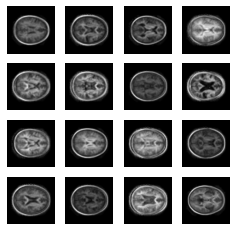

In [5]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, 6):
    start_time = time.time()
    training_loss = -1
    ssim = 0
    for train_x in train_dataset:
        training_loss = model.train(train_x)
        recon = model.model(train_x)
        ssim += tf.image.ssim(train_x, recon, max_val=1.0, filter_size=11,
                            filter_sigma=1.5, k1=0.01, k2=0.03)
    end_time = time.time()
    test_loss = 0
    for t in test_dataset:
        test_loss += model.get_loss(t)
    display.clear_output(wait=False)
#     print_generation_ssim()
    print(f"Reconstruction SSIM: {tf.reduce_mean(ssim, axis=None) / len(train_dataset)}")
    print(f"Epoch: {epoch}, Test set Loss: {test_loss/len(test_dataset)}, Training set loss: {training_loss}, time elapse for current epoch: {end_time - start_time}")
    generate_and_save_images(model, epoch, random_vector_for_generation)